<a href="https://colab.research.google.com/github/RodrickGulu/Final_Year_Project/blob/main/training_model_with_blurry_image_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


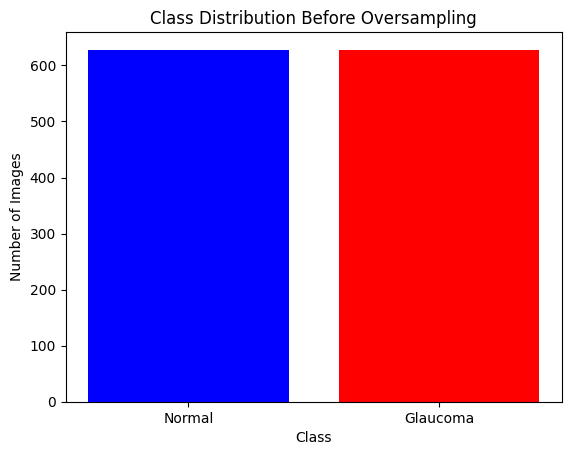

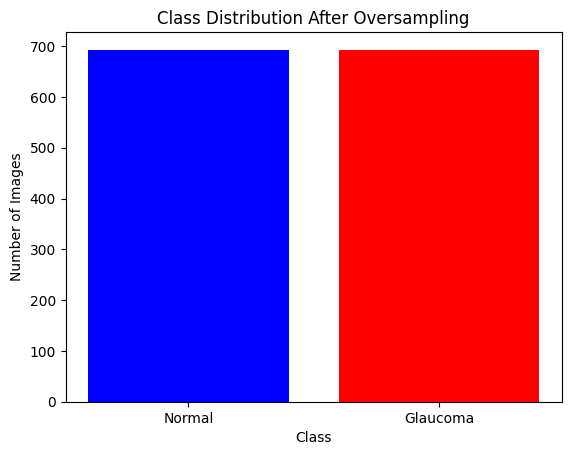

Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 14.7160 - accuracy: 0.6656
Epoch 1: val_accuracy improved from -inf to 0.65468, saving model to vgg19_glaucoma_ensemble_0.h5
32/32 [==============================] - 13s 350ms/step - loss: 14.7160 - accuracy: 0.6656 - val_loss: 1.2238 - val_accuracy: 0.6547
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - ETA: 0s - loss: 2.2876 - accuracy: 0.8597
Epoch 2: val_accuracy improved from 0.65468 to 0.80576, saving model to vgg19_glaucoma_ensemble_0.h5
32/32 [==============================] - 8s 252ms/step - loss: 2.2876 - accuracy: 0.8597 - val_loss: 0.7105 - val_accuracy: 0.8058
Epoch 3/20
32/32 [==============================] - ETA: 0s - loss: 0.9703 - accuracy: 0.9374
Epoch 3: val_accuracy improved from 0.80576 to 0.82734, saving model to vgg19_glaucoma_ensemble_0.h5
32/32 [==============================] - 7s 235ms/step - loss: 0.9703 - accuracy: 0.9374 - val_loss: 0.7211 - val_accuracy: 0.8273
Epoch 4/20
32/32 [==============================] - ETA: 0s - loss: 0.4770 - accuracy: 0.9727
Epoch 4: val_accuracy improved from 0.82734 to 0.84892, saving model to vgg19_glaucoma_ensemble_0.h5
32/32 [==============================] - 8s 257ms/step - loss: 0.4770 - accuracy: 0.9727 - val_loss: 0.6683 - val_accuracy: 0.8489
Epoch 5/20
32/32 [===============

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

def load_images_from_folder(folder_path):
    images = []
    labels = []

    for folder_name in os.listdir(folder_path):
        folder = os.path.join(folder_path, folder_name)
        if not os.path.isdir(folder):
            continue

        label = 1 if folder_name == "glaucoma" else 0

        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))
            if img is not None:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                blur = cv2.Laplacian(gray, cv2.CV_64F).var()

                # Set a threshold for blur
                if blur > 20:
                    images.append(img)
                    labels.append(label)

    return np.array(images), np.array(labels)

# Load images from the folder
dataset_path = '/content/drive/MyDrive/glaucoma_dataset/training'
images, labels = load_images_from_folder(dataset_path)

# Count the number of images in each class before oversampling
class_counts_before_oversampling = np.bincount(labels)
class_names = ["Normal", "Glaucoma"]

# Plot bar chart for class distribution before oversampling
plt.bar(class_names, class_counts_before_oversampling[1:], color=['blue', 'red'])
plt.title('Class Distribution Before Oversampling')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

# Apply oversampling using SMOTE
oversample = SMOTE(sampling_strategy='auto', random_state=42)
x_resampled, y_resampled = oversample.fit_resample(images.reshape(-1, 224 * 224 * 3), labels)

# Reshape back to image format
x_resampled = x_resampled.reshape(-1, 224, 224, 3)

# Count the number of images in each class after oversampling
class_counts_after_oversampling = np.bincount(y_resampled)
class_names = ["Normal", "Glaucoma"]

# Plot bar chart for class distribution after oversampling
plt.bar(class_names, class_counts_after_oversampling[1:], color=['blue', 'red'])
plt.title('Class Distribution After Oversampling')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

# Split the resampled data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.1)

# Model architecture
def create_model():
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    for layer in vgg.layers:
        layer.trainable = False

    model = Sequential()
    model.add(vgg)
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Create an ensemble of three models
num_models = 3
models = [create_model() for _ in range(num_models)]

class_weights = {0: 5, 1: 7}  # You can adjust the weights based on your preference

# Model callbacks for each model
callbacks_list = [ModelCheckpoint(f"vgg19_glaucoma_ensemble_{i}.h5", monitor="val_accuracy", verbose=1, save_best_only=True, save_weights_only=False, period=1) for i in range(num_models)]

# Training each model in the ensemble
histories = []
for i in range(num_models):
    history = models[i].fit(x_train, y_train, batch_size=40, epochs=20, validation_data=(x_test, y_test), verbose=1, callbacks=[callbacks_list[i], EarlyStopping(monitor="val_accuracy", patience=10, verbose=1)], class_weight=class_weights)
    histories.append(history)

# Combine predictions from all models using voting
ensemble_predictions = np.mean([model.predict(x_test) for model in models], axis=0)
ensemble_predictions_binary = (ensemble_predictions > 0.5).astype(int)

# Evaluate the ensemble
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions_binary)
print("Ensemble Accuracy Score:", ensemble_accuracy)


Classification Report for Ensemble Predictions:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        71
           1       0.85      0.85      0.85        68

    accuracy                           0.86       139
   macro avg       0.86      0.86      0.86       139
weighted avg       0.86      0.86      0.86       139

Confusion Matrix for Ensemble Predictions:
[[61 10]
 [10 58]]


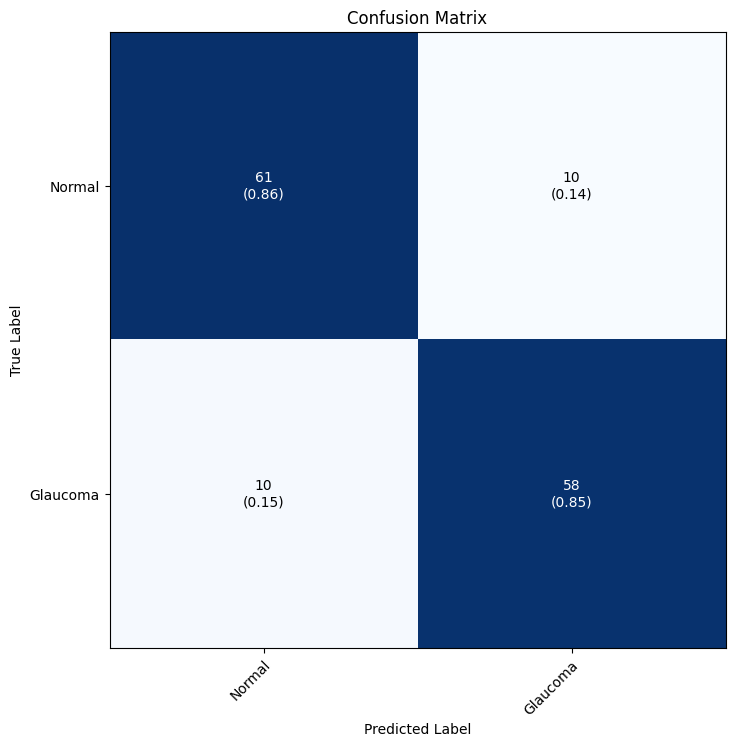

In [ ]:
# Compute the confusion matrix
# Evaluating the model
ensemble_classification_report = classification_report(y_test, ensemble_predictions_binary)
print("Classification Report for Ensemble Predictions:")
print(ensemble_classification_report)

cm = confusion_matrix(y_test, ensemble_predictions_binary)
print("Confusion Matrix for Ensemble Predictions:")
print(cm)

# Plot the confusion matrix
plot_confusion_matrix(conf_mat=cm, figsize=(8, 8), class_names=["Normal", "Glaucoma"], show_normed=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

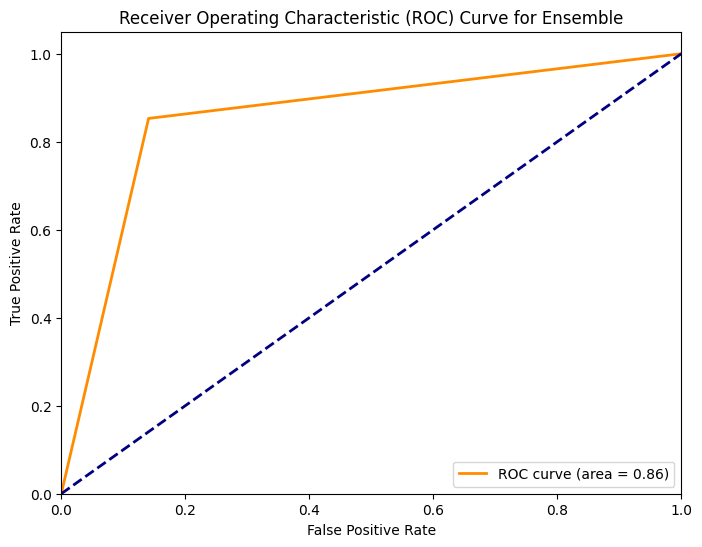

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, ensemble_predictions_binary)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Ensemble')
plt.legend(loc='lower right')
plt.show()
